# Intro

This notebook describes the frontier exploration SMACH program methodology thus far.  

## Previous Work
### Frontier Exploration Node
The first iteration of the Frontier Exploration experiment was using the [frontier exploration node](http://wiki.ros.org/frontier_exploration "Frontier Exploration ROS") for ROS Kinetic. However, due to the poor implementation of move_base and other factors, this was abondoned for other methods.

### Spiral Heuristic
The second iteration focused on implementing a spiral heuristic for the robot in ROS. Move base commands were given that forced the robot to move in an outward growing spiral from the (0,0) origin point. This method yielded a more reliable map though still was not a high enough fidelity for the need.

### Voronoi Heuristic
Given the flaws in the node and the spiral heuristic - chiefly, the low resolution maps and dependence on rectangular Gazebo worlds, a Voronoi approach was attempted. In the first iteration, Voronoi regions were constructed and the robot was instructed to move between the seed locations in the map. This yeilded a map that was not rectangularly-dependent, though still of a low resolution.

### Voronoi Strings
This article follow the 4th iteration in the frontier exploration experiment - constructing strings of move base goals within each Voronoi region. Then, these regions can be either shortened, lengthened, multiplied, etc. to accommodate strings of varying lengths. See below for additional details.

In [2]:
import sys
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import numpy as np
import random

from math import pi

In [4]:
%matplotlib inline

In [5]:
def voronoi_finite_polygons_2d(vor, radius=None):
    
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.array(new_vertices)

#### Constructing the Voronoi plot
Orange points - Voronoi vertices 

Grey points - Seed points 

Hard lines - Voronoi ridge lines 

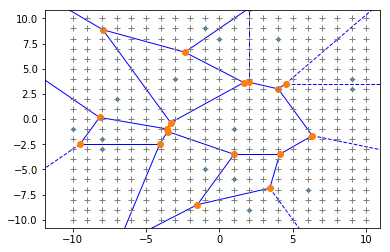

In [6]:
# Params from Gazebo
length = 20 
width = 20

N = 15 # Number of voronoi points to create
spacing = 1 # Spacing between movebase points

d = False

# creating random points across the area
x = [random.randrange(-length/2, length/2) for i in range(N)]
y = [random.randrange(-width/2, width/2) for i in range(N)]
points = np.array(list(zip(x, y)))

vor = Voronoi(points, qhull_options='Qbb Qc Qx') # Create the voronoi
fig = voronoi_plot_2d(vor, line_colors='b')

if d:
    tri = Delaunay(points, qhull_options='Qbb Qc Qx') # Create a delaunay grid 
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    plt.plot(points[:,0], points[:,1], 'o')

x_grid = np.arange(-length/2, length/2 + 1, step=spacing)
y_grid = np.arange(-width/2, width/2 + 1, step=spacing)
xx, yy = np.meshgrid(x_grid, y_grid)
plt.plot(xx, yy, '+', c='grey')
plt.show()

Now, if we were to be using the third approach from above, we would simply move the robot between the seed points. As you can see by the plot below, this leaves out significant regions of the map and has little difference from simply generating random points within a world.

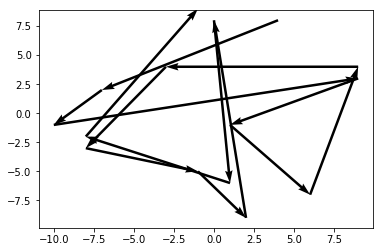

In [7]:
x_vert, y_vert = [], []

for i, reg in enumerate(vor.regions):
    x_vert.append(points[i][0])
    y_vert.append(points[i][1])
    
x_vert = np.array(x_vert)
y_vert = np.array(y_vert)
    
plt.figure()
plt.quiver(x_vert[:-1], y_vert[:-1], x_vert[1:]-x_vert[:-1], y_vert[1:]-y_vert[:-1], scale_units='xy', angles='xy', scale=1)
plt.show()

Instead, we can again create the regions (shown by different colors below) with their seed points highlighted in black.

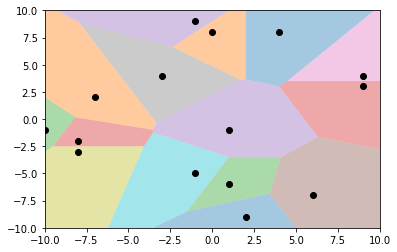

In [8]:
regions, vertices = voronoi_finite_polygons_2d(vor)

fig = plt.plot(points[:,0], points[:,1], 'ko')

for region in regions:
    # Color polygon
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.xlim(-length/2, length/2)
plt.ylim(-width/2, width/2)
plt.show()

Then, we can construct line segments made of any length of points in each of these regions. The length of the line as well as the number of lines constructed in each region can then be adjusted to fullfill any level of fidelity map desired.

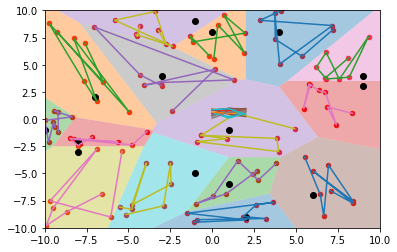

<Figure size 1440x1440 with 0 Axes>

In [9]:
boundary = Polygon([(-width/2, -length/2), (-width/2, length/2), (width/2, length/2), (width/2, -length/2)])
regions, vertices = voronoi_finite_polygons_2d(vor)
line_length = 8

fig = plt.plot(points[:,0], points[:,1], 'ko')

for region in regions:
    # Color polygon
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)
    # Find boundary points
    poly = Polygon(polygon)
    poly = poly.intersection(boundary)
    min_x, min_y, max_x, max_y = poly.bounds
    # get random line within region
    poly_points = []
    while len(poly_points) < line_length:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            poly_points.append(random_point)
    plt.scatter([point.x for point in poly_points], [point.y for point in poly_points], s=20, c='r')
    plt.plot([point.x for point in poly_points], [point.y for point in poly_points], np.random.rand(3,))

plt.xlim(-length/2, length/2)
plt.ylim(-width/2, width/2)
plt.figure(figsize=(20,20))
plt.show()

Now, we can parameterize this function and pass through each region, finding chains of points to then pass to move_base in ROS. The SMACH implementation is in development.

## Future Work
In the future, such a program may be better suited for ROSPlan or some other form of behavior tree algorithm because the core functionality of the program is then unhampered by arbitrary measures of iteration times, rather, by a problem statement that defines what a successful map looks like. 

## Test for multiple iterations in each region

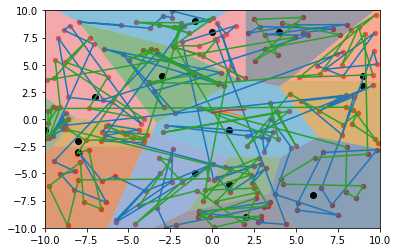

<Figure size 1440x1440 with 0 Axes>

In [18]:
boundary = Polygon([(-width/2, -length/2), (-width/2, length/2), (width/2, length/2), (width/2, -length/2)])
regions, vertices = voronoi_finite_polygons_2d(vor)
line_length = 8

fig = plt.plot(points[:,0], points[:,1], 'ko')

# poly_points = []

for i in range(2): # repeat this computation 
    poly_points = []
    for region in regions:
        # Color polygon
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4)
        # Find boundary points
        poly = Polygon(polygon)
        poly = poly.intersection(boundary)
        min_x, min_y, max_x, max_y = poly.bounds
        # get random line within region
        count = 0
        while count < line_length:
            random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
            if (random_point.within(poly)):
                poly_points.append(random_point)
                count += 1
                
    plt.scatter([point.x for point in poly_points], [point.y for point in poly_points], s=20, c='r')
    plt.plot([point.x for point in poly_points], [point.y for point in poly_points], np.random.rand(3,))

plt.xlim(-length/2, length/2)
plt.ylim(-width/2, width/2)
plt.figure(figsize=(20,20))
plt.show()

As shown, each iteration, more of the map is exposed